In [20]:
import pandas as pd #importing Pandas & Numpy for data analysis
import numpy as np
import re
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import math
import scipy as stats

In [21]:
df = pd.read_csv("Saureus_isolates_all_v1.csv") #reading the Staphylococcus aureus dataset (CSV)

In [22]:
#Renaming the relevant columns:
df.rename(columns={"#Organism group": "organism_group",
           "Strain": "strain",
           "Isolate": "isolate",
           "Create date": "create_date",
           "Location": "location",
           "Isolation source": "isolation_source",
           "AMR genotypes": "amr_genotypes",
           "Virulence genotypes": "virulence_genotypes",
           "Stress genotypes": "stress_genotypes",
           "AST phenotypes": "ast_phenotypes",
           "Host disease": "host_disease"
           },
           inplace=True
           )

In [23]:
#deleting non-relevant rows:
#I realised that there are rows that should not be included in the analysis. I will delete those rows since my analysis is strictly focused on clinical settings:
df = df[df["isolation_source"].str.contains("Nursing home")==False]
df = df[df["isolation_source"].str.contains("household surface")==False]
df = df[df["isolation_source"].str.contains("Facility")==False]
df = df[df["isolation_source"].str.contains("laboratory mutant")==False]
df = df[df["isolation_source"].str.contains("host")==False]

In [24]:
#Lets clean the columns:
#DATE: To clean it, we convert it to datetime and then, create 2 new columns, one for the year and another for the month.
df["create_date"] = pd.to_datetime(df["create_date"])
df["year"] = df["create_date"].dt.year
df["month"] = df["create_date"].dt.month
df.drop(columns="create_date", axis=1, inplace=True)

In [25]:
#casting my relevant columns so that I can later work with them:
df["isolation_source"] = df["isolation_source"].astype(str)
df["virulence_genotypes"] = df["virulence_genotypes"].astype(str)
df["stress_genotypes"] = df["stress_genotypes"].astype(str)
df["host_disease"] = df["host_disease"].astype(str)

In [26]:
#Cleaning functions:
def get_state(location: str) -> str:
    state_eq = {
        "Alabama": ["Alabama","AL"],
        "Alaska": ["Alaska","AK"],
        "Arizona": ["Arizona","AZ"],
        "Arkansas": ["Arkansas","AR"],
        "California": ["California","CA"],
        "Colorado": ["Colorado","CO"],
        "Connecticut": ["Connecticut","CT"],
        "Delaware": ["Delaware","DE"],
        "Florida": ["Florida","FL"],
        "Georgia": ["Georgia","GA"],
        "Hawaii": ["Hawaii","HI"],
        "Idaho": ["Idaho","ID"],
        "Illinois": ["Illinois", "IL"],
        "Indiana": ["Indiana", "IN"],
        "Iowa": ["Iowa", "IA"],
        "Kansas": ["Kansas", "KS"],
        "Kentucky": ["Kentucky", "KY"],
        "Louisiana": ["Lousiana", "LA"],
        "Maine": ["Maine","ME"],
        "Maryland": ["Maryland", "MD"],
        "Massachusetts": ["Massachusetts", "MA"],
        "Michigan": ["Michigan", "MI"],
        "Minnesota": ["Minnesota", "MN"],
        "Mississippi":["Mississippi", "MS"],
        "Missouri": ["Missouri", "MO"],
        "Montana": ["Montana", "MT"],
        "Nebraska": ["Nebraska", "NE"],
        "Nevada": ["Nevada", "NV"],
        "New Hampshire": ["New Hampshire", "NH"],
        "New Jersey": ["New Jersey", "NJ"],
        "New Mexico": ["New Mexico", "NM"],
        "New York": ["New York", "NY"],
        "North Carolina": ["North Carolina", "NC"],
        "North Dakota": ["North Dakota", "ND"],
        "Ohio": ["Ohio", "OH"],
        "Oklahoma": ["Oklahoma", "OK"],
        "Oregon": ["Oregon", "OR"],
        "Pennsylvania": ["Pennsylvania", "PA"],
        "Rhode Island": ["Rhode Island", "RI"],
        "South Carolina": ["South Carolina", "SC"],
        "South Dakota": ["South Dakota", "SD"],
        "Tennessee": ["Tennessee", "TN"],
        "Texas": ["Texas", "TX"],
        "Utah": ["Utah", "UT"],
        "Vermont": ["Vermont", "VT"],
        "Virginia": ["Virginia", "VA"],
        "Washington": ["Washington", "WA"],
        "West Virginia": ["West Virginia", "WV"],
        "Wisconsin": ["Wisconsin", "WI"],
        "Wyoming": ["Wyoming", "WY"]
        }
    location = location.lower()
    for state_category, state_equivalents in state_eq.items():
        for state_equivalent in state_equivalents:
            if re.search(rf'\b{state_equivalent.lower()}\b', location):
                return state_category
    return "USA"


def isolation_category(isolate: str) -> str:
    isolate = isolate.lower()
    if isolate == "non-icu":
        return "other/undefined"
    isolation_dict = {
        "respiratory system": [ "sputum or oropharyngeal", "nasal surveillance",
        "respiratory", "nasal perirectal swab", "pharyngeal", "nasal",
        "nose", "sputum", "throat", "nasal","resp", "phar", "lung", "sput", 
        "swab", "nares", "trach", "aspirate", "airway", "airway culture",
        "bronch", "alv", "oroph", "trach", "anterior", "naris", "empyema",
        "cystic fibrosis airway culture", "washing", "lavage", "bronco",
        "anterior",
        
    ],
    "skin and soft tissue": [ "skin/soft", "soft tissue", "cutaneous wound", "cxwnd",
        "soft", "cutaneous", "wound", "skin", "soft", "palm", "axilla", "tendon",
        "ssti", "groin", "abscess", "ulcer", "skin-ad site", "otic", "ear", "thigh",
        "palm", "leg", "foot", "cellu", "pust", "nasal-perirectal swab", "buttocks", "skin-perianal",
    ],
    "bloodstream and cardiovascular system": ["blood culture", "pericardial",
       "blood", "endovascular","bacteremia", "rural", "endo", "regional", "blood from patients of rural regional hospital", "tip",
    ],
    "urinary system": [
        "urine", "urine (nephrostomy)", "urine from long term care facility", 
        "urethra", "nephrostomy", "nephrostomy", "urogenital tract"
    ],
    "gastrointestinal system": [
        "stool", "ascitic fluid", "peritoneal fluid", "peritoneal fluid inpatient/outpatient", 
        "bile", "gastric aspirate", "rectal swab", "abdominal fluid", "peritoneal fluid", 
        "peritoneal fluid", "stool of child with non-specific diarrhea", "peritoneum infection", 
        "abdominal wound", "necrotizing", "peritoneum infection", "thymic + pleural effusion", 
        "fluid, pericardial", "stool", "rectal swab", "drainage"
    ],
    "musculoskeletal system": [
        "bone", "joint", "synovial", "marrow", "osteom", "knee", "elbow", "hip", "fluid",
        "prosthetic", "implant", "sonicate", "back", "femur", "footpad", "hardware", "marrow",
    ],
    "reproductive system": [
    "vaginal swab", "cervical swab", "semen", "endometrial biopsy", "labia abscess", "penis"
    ],
    "neonatal and pediatric sources": [
        "umbilical swab", "neonatal sepsis", "meconium", "amniotic fluid", "umbilicus swab", 
        "umbilicus", "umbilicus", "newborn nursery", "umbilicus swab"
    ],
    "icu (intensive care unit)": ["icu"],
    "ocular": ["corneal", "conjuntiva", "eye"]
    }
    for isolate_category, isolate_equivalents in isolation_dict.items():
        for isolate_equivalent in isolate_equivalents:
            if re.search(rf'\b{isolate_equivalent}\b', isolate):
                return isolate_category
    return "other/undefined"

def genotype_clean(genotype: str):
    gen = genotype.split(",")
    genes=[]
    for gene in gen:
        split_gene = gene.split("=")[0]
        genes.append(split_gene)

    return genes

#defining a function for creating a dictionary for the ast_phenotype:
def phenotype_clean(phenotype: str) -> dict:
    phen = phenotype.split(",")
    phen_dict = {}
    for string in phen:
        phen = string.split("=")
        if len(phen) != 2:
            return np.nan
        phen_dict[phen[0]] = phen[1]
    return phen_dict

#defining a function to clean the host_disease column:
def host_disease_clean(disease: str) -> str:
    disease = disease.lower()
    disease_dict = {
        "infections":
        [
        "staphylococcus aureus bacteremia", "bacteremia", "bacterial infectious disease", "infection",
        "ulcer", "diabetic", "cellular", "pneumonia", "ssti", "atopic dermatitis", "dermatitis", "atopic",
        "sepsis", "skin", "keratitis", "conjunctivitis", "bloodstream", "infections", "synovitis", "uti", "urinary",
        "central line", "staphylococcal", "bloodstream infection", "eye", "spinal osteomyelitis","pneumonia", "osteomyelitis",
        "septicemia", "microbial", "health care", "associated", "healh care associated", "abcess", "purulent", "spongiotic dermatitis",
        "spongiotic", "pododermatitis", "tricuspid valve", "itis", "pododermatitis", "skin and soft tissue infection", "respiratory", 
        "fatal", "cellulitis", "abscess", "surgical", "surgical wound", "wound", "toxic shock syndrome", "toxic", "infective",
        "infective endocarditis", "sepsis", "persistent", "septicemia", "fatal septicaemia and septic arthritis", "peritonitis",
        "breast implant", "implant", "associated", "severe", "syndrome", "pyelonephritis", "necro", "nectrotizing", "fascitis", 
        "mrsa", "cirurgical wound", "pericarditis", "hepatitis", "lesion", "control", "septic", "pulmonary", "emboly", "burn", "device-related",
        "prolonged", "corneal", "ulcer", "arthritis", "anemia", "loss", "levamisole vasculitis", "ventilator", "ventilator-associated", "associated",
        "non-healing", "embolism", "urosepsis", "exacerbation", "prosth", "prosthetic", "joint", "polymicrobial", "delayed", "pneumonitis", "vertebral"
        ],
        "chronic conditions":
        [
        "cystic fibrosis", "fibrosis", "chronic", "bullous pemphigoid", "charcot arthropathy",
        ],
         "asymptomatic/colonization":
        [
        "asymptomatic colonization", "asymptomatic", "colonization", "comensal", "carriage", "screening culture", 
        "screening isolate", "surveillance swab", "surveillance", "screening swab", "screening", "healthy", 
        "commensal", 
        ],
        "not collected/not applicable":
        [
        "not collected", "not applicable"
        ]
    }
    for disease_category, disease_equivalents in disease_dict.items():
        for disease_equivalent in disease_equivalents:
            if re.search(rf'\b{disease_equivalent}\b', disease):
                return disease_category
    return "other/undefined"
    

In [27]:
#calling the functions:
df["location"] = df["location"].apply(get_state)
df["isolation_source"] = df["isolation_source"].apply(isolation_category)
df["amr_genotypes"] = df["amr_genotypes"].apply(genotype_clean)
df["virulence_genotypes"] = df["virulence_genotypes"].apply(genotype_clean)
df["stress_genotypes"] = df["stress_genotypes"].apply(genotype_clean)
df["ast_phenotypes"] = df["ast_phenotypes"].astype(str)
df["ast_phenotypes"] = df["ast_phenotypes"].apply(phenotype_clean)
df["host_disease"] = df["host_disease"].apply(host_disease_clean)

In [28]:
df2 = pd.read_csv("Spseudo_isolates_all_v1.csv") #reading the Staphylococcus pseudiintermedius dataset (CSV)

In [29]:
#Renaming the relevant columns:
df2.rename(columns={"#Organism group": "organism_group",
           "Strain": "strain",
           "Isolate": "isolate",
           "Create date": "create_date",
           "Location": "location",
           "Isolation source": "isolation_source",
           "AMR genotypes": "amr_genotypes",
           "Virulence genotypes": "virulence_genotypes",
           "Stress genotypes": "stress_genotypes",
           "AST phenotypes": "ast_phenotypes",
           "Host disease": "host_disease"
           },
           inplace=True
           )

In [30]:
#deleting non-relevant rows:
#I realised that there are rows that should not be included in the analysis. I will delete those rows since my analysis is strictly focused on clinical settings:
df2 = df2[df2["isolation_source"].str.contains("Nursing home")==False]
df2 = df2[df2["isolation_source"].str.contains("household surface")==False]
df2 = df2[df2["isolation_source"].str.contains("Facility")==False]
df2 = df2[df2["isolation_source"].str.contains("laboratory mutant")==False]
df2 = df2[df2["isolation_source"].str.contains("host")==False]

In [31]:
#Lets clean the columns:
#DATE: To clean it, we convert it to datetime and then, create 2 new columns, one for the year and another for the month.
df2["create_date"] = pd.to_datetime(df2["create_date"])
df2["year"] = df2["create_date"].dt.year
df2["month"] = df2["create_date"].dt.month
df2.drop(columns="create_date", axis=1, inplace=True)

In [32]:
#casting my relevant columns so that I can later work with them:
df2["isolation_source"] = df2["isolation_source"].astype(str)
df2["amr_genotypes"] = df2["amr_genotypes"].astype(str)
df2["virulence_genotypes"] = df2["virulence_genotypes"].astype(str)
df2["stress_genotypes"] = df2["stress_genotypes"].astype(str)
df2["host_disease"] = df2["host_disease"].astype(str)

In [33]:
#calling the functions:
df2["location"] = df2["location"].apply(get_state)
df2["isolation_source"] = df2["isolation_source"].apply(isolation_category)
df2["amr_genotypes"] = df2["amr_genotypes"].apply(genotype_clean)
df2["virulence_genotypes"] = df2["virulence_genotypes"].apply(genotype_clean)
df2["stress_genotypes"] = df2["stress_genotypes"].apply(genotype_clean)
df2["ast_phenotypes"] = df2["ast_phenotypes"].astype(str)
df2["ast_phenotypes"] = df2["ast_phenotypes"].apply(phenotype_clean)
df2["host_disease"] = df2["host_disease"].apply(host_disease_clean)

In [34]:
#now the the data is cleaned in both dataframes (for s. aureus and s.pseudo, I can concatenate both dataframes:
df3  = pd.concat([df, df2], axis=0, keys=["S. aureus", "S. pseudo"])

In [35]:
#now that i have the data cool, i can do a small EDA (Exploratory Data Analysis)
df3.head()

organism_group   strain         isolate       location  \
S. aureus 1    Staphylococcus aureus  CIG1057  PDT000009286.3            USA   
          2    Staphylococcus aureus  CIG1096  PDT000009319.3            USA   
          7    Staphylococcus aureus       M2  PDT000012543.3            USA   
          150  Staphylococcus aureus    M0104  PDT000014030.3  Massachusetts   
          151  Staphylococcus aureus    M0171  PDT000014031.3  Massachusetts   

                                    isolation_source  \
S. aureus 1    bloodstream and cardiovascular system   
          2    bloodstream and cardiovascular system   
          7                          other/undefined   
          150              icu (intensive care unit)   
          151              icu (intensive care unit)   

                                                   amr_genotypes  \
S. aureus 1    [ant(9)-Ia, blaI, blaR1, blaZ, erm(A), fosB, g...   
          2    [aadD1, ant(9)-Ia, ant(9)-Ia, blaI, blaR1, bla...   
          7    [aac(6')-Ie/aph(2'')-Ia, ant(6)-Ia, ant(9)-Ia,...   
          150  [aadD1, abc-f, ant(6)-Ia, ant(9)-Ia, aph(3')-I...   
          151  [aadD1, abc-f, ant(6)-Ia, ant(9)-Ia, aph(3')-I...   

                                             virulence_genotypes  \
S. aureus 1    [aur, hld, hlgA, hlgB, hlgC, icaC, lukD, lukE,...   
          2    [aur, hld, hlgA, hlgB, hlgC, icaC, lukD, lukE,...   
          7    [aur, hld, hlgA, hlgB, hlgC, icaC, sak, scn, s...   
          150  [aur, hld, hlgA, hlgB, hlgC, icaC, lukD, lukE,...   
          151  [aur, hld, hlgA, hlgB, hlgC, icaC, lukD, lukE,...   

                                         stress_genotypes ast_phenotypes  \
S. aureus 1    [arsB, arsB, arsB, arsC, arsR, cadD, lmrS]            NaN   
          2                            [arsB, cadD, lmrS]            NaN   
          7                            [arsB, lmrS, qacC]            NaN   
          150                          [arsB, cadD, lmrS]            NaN   
          151                          [arsB, cadD, lmrS]            NaN   

                  host_disease  year  month  
S. aureus 1    other/undefined  2012     10  
          2    other/undefined  2012     10  
          7    other/undefined  2012     10  
          150  other/undefined  2013      4  
          151  other/undefined  2013      4

In [36]:
df3.shape

(18711, 12)

In [37]:
#let's see my nulls
df3.isnull() #i see that i only have null values in the ast_phenotypes column, which is ok. actually i only have 61 rows that actually contain ast_phenotypes.

organism_group  strain  isolate  location  isolation_source  \
S. aureus 1             False   False    False     False             False   
          2             False   False    False     False             False   
          7             False   False    False     False             False   
          150           False   False    False     False             False   
          151           False   False    False     False             False   
...                       ...     ...      ...       ...               ...   
S. pseudo 956           False    True    False     False             False   
          957           False    True    False     False             False   
          958           False    True    False     False             False   
          959           False    True    False     False             False   
          960           False   False    False     False             False   

               amr_genotypes  virulence_genotypes  stress_genotypes  \
S. aureus 1            False                False             False   
          2            False                False             False   
          7            False                False             False   
          150          False                False             False   
          151          False                False             False   
...                      ...                  ...               ...   
S. pseudo 956          False                False             False   
          957          False                False             False   
          958          False                False             False   
          959          False                False             False   
          960          False                False             False   

               ast_phenotypes  host_disease   year  month  
S. aureus 1              True         False  False  False  
          2              True         False  False  False  
          7              True         False  False  False  
          150            True         False  False  False  
          151            True         False  False  False  
...                       ...           ...    ...    ...  
S. pseudo 956            True         False  False  False  
          957            True         False  False  False  
          958            True         False  False  False  
          959            True         False  False  False  
          960            True         False  False  False  

[18711 rows x 12 columns]

In [38]:
#let's check the data distribution of unique values
df3["organism_group"].value_counts()

organism_group
Staphylococcus aureus              17750
Staphylococcus pseudintermedius      961
Name: count, dtype: int64

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/117581153.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df3.organism_group, palette=colors)


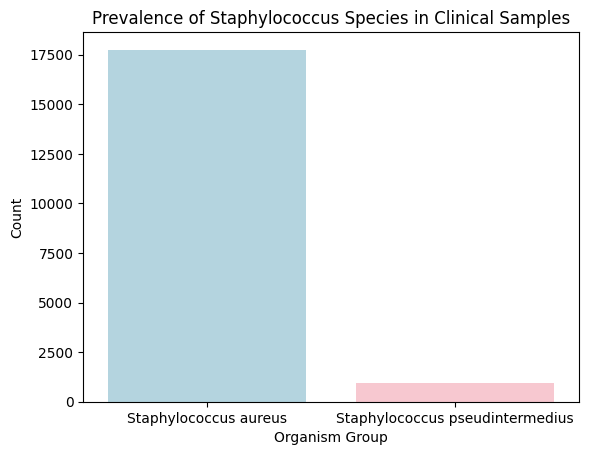

In [58]:
#now, I want to graphically see the counts for each species
colors = ['lightblue', 'pink']
sns.countplot(x=df3.organism_group, palette=colors)

plt.xlabel('Organism Group')
plt.ylabel('Count')
plt.title('Prevalence of Staphylococcus Species in Clinical Samples')

plt.show()

In [40]:
#let's analyse the "isolation_source "column. I see that the majority of the data is until oither/undefined. So I will count the top 4 isolaiton sources.
df3["isolation_source"].value_counts()

isolation_source
respiratory system                       8679
bloodstream and cardiovascular system    3668
skin and soft tissue                     3419
other/undefined                          2318
musculoskeletal system                    232
urinary system                            217
ocular                                     89
gastrointestinal system                    56
neonatal and pediatric sources             19
icu (intensive care unit)                  13
reproductive system                         1
Name: count, dtype: int64

In [41]:
df3["isolation_source"].value_counts().head(4) #These are the results I gett by using head(4). Now, it will be great to do a pie chart to see the % of each isolation source.

isolation_source
respiratory system                       8679
bloodstream and cardiovascular system    3668
skin and soft tissue                     3419
other/undefined                          2318
Name: count, dtype: int64

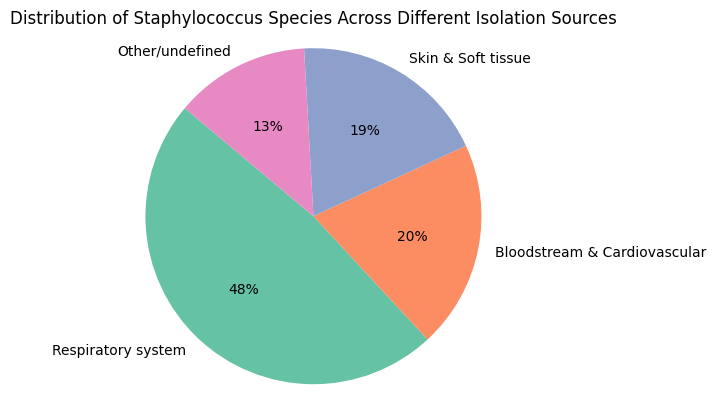

In [60]:
#let's try plotting the pie chart:
labels = ['Respiratory system', 'Bloodstream & Cardiovascular', 'Skin & Soft tissue', 'Other/undefined']
sizes = [48, 20, 19, 13]
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Staphylococcus Species Across Different Isolation Sources')
plt.show()

In [43]:
#let's do the same for the host_disease column:
df3["host_disease"].value_counts()

host_disease
other/undefined                 6426
infections                      5168
asymptomatic/colonization       4366
not collected/not applicable    1556
chronic conditions              1195
Name: count, dtype: int64

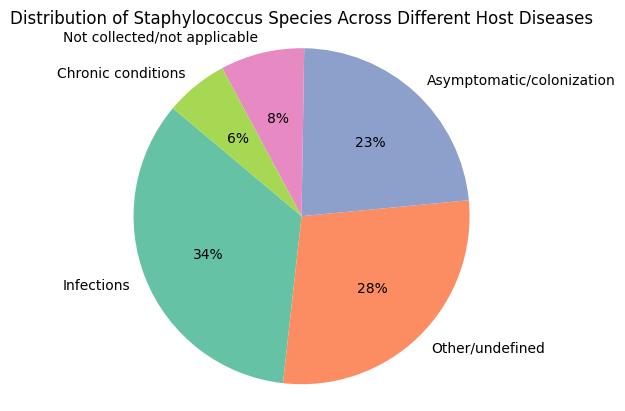

In [59]:
#let's do the same for the host_disease column:

labels = ['Infections', 'Other/undefined', 'Asymptomatic/colonization', 'Not collected/not applicable', 'Chronic conditions']
sizes = [34, 28, 23, 8, 6]
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors, startangle=140)
ax.axis('equal')

plt.title('Distribution of Staphylococcus Species Across Different Host Diseases')
plt.show()

In [45]:
#Ok, now that I have these columns, let's check the "location" column:
df3["location"].value_counts()

location
USA               5707
Pennsylvania      4963
Massachusetts     1396
Iowa              1373
New York          1285
California        1104
Georgia            495
Maryland           278
Texas              278
Michigan           207
Minnesota          181
Arizona            169
Florida            163
Missouri           154
Mississippi        149
Illinois           115
Colorado           104
North Carolina     102
Kansas              82
Ohio                77
Nebraska            54
Kentucky            34
Alabama             32
Indiana             29
Washington          28
Wisconsin           28
North Dakota        24
Louisiana           23
Tennessee           14
Oregon              13
South Dakota        12
Montana             10
Hawaii               9
South Carolina       6
Maine                4
New Mexico           2
Idaho                2
Virginia             2
Vermont              1
Delaware             1
Connecticut          1
Name: count, dtype: int64

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/3889792150.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='location_grouped', data=df3, order=df3['location_grouped'].value_counts().index, palette="pastel")


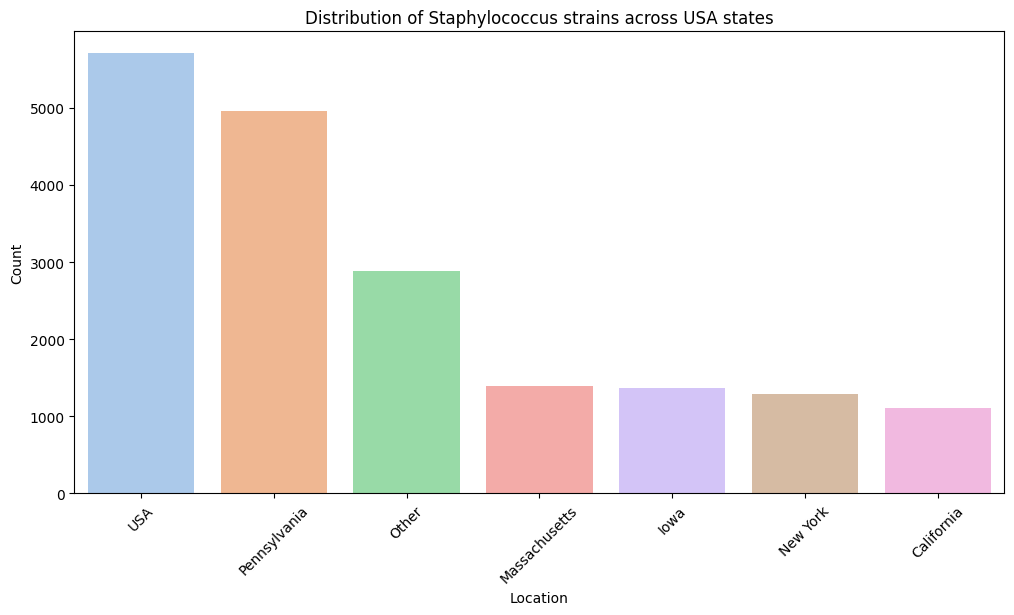

In [63]:
# Defining the threshold for most frequent states
threshold = 1000
location_counts = df3["location"].value_counts()
df3['location_grouped'] = df3['location']
df3.loc[df3['location'] == 'USA', 'location_grouped'] = 'USA'
df3.loc[(df3['location'] != 'USA') & (df3['location'].map(location_counts) < threshold), 'location_grouped'] = 'Other'

plt.figure(figsize=(12, 6))
sns.countplot(x='location_grouped', data=df3, order=df3['location_grouped'].value_counts().index, palette="pastel")
plt.xticks(rotation=45)
plt.title('Distribution of Staphylococcus strains across USA states')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()


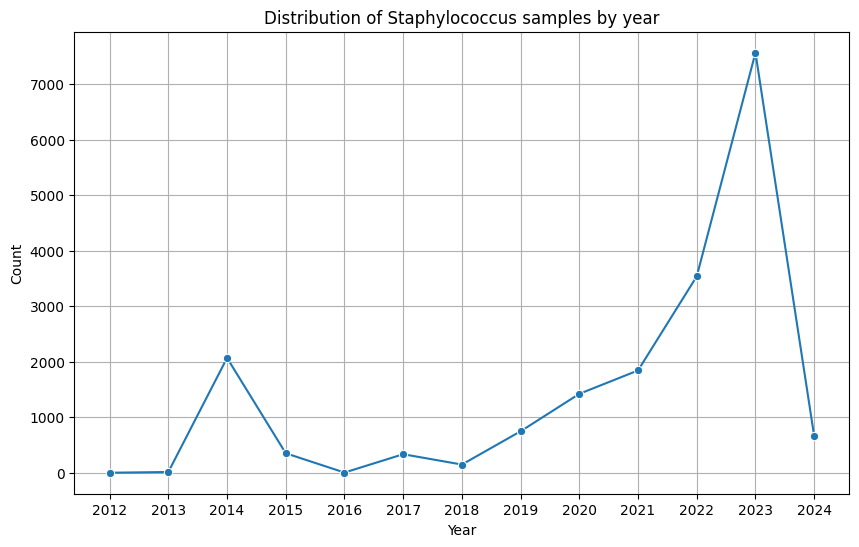

In [47]:
#Now, let's see ewhat we can do with year and month columns

year_counts = df3['year'].value_counts().sort_index()

year_counts_df = year_counts.reset_index()
year_counts_df.columns = ['year', 'count']

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='count', data=year_counts_df, marker='o')
plt.title('Distribution of Staphylococcus samples by year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(year_counts_df['year'])
plt.grid(True)
plt.show()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/1216366339.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='count', data=month_counts_df, palette="magma")


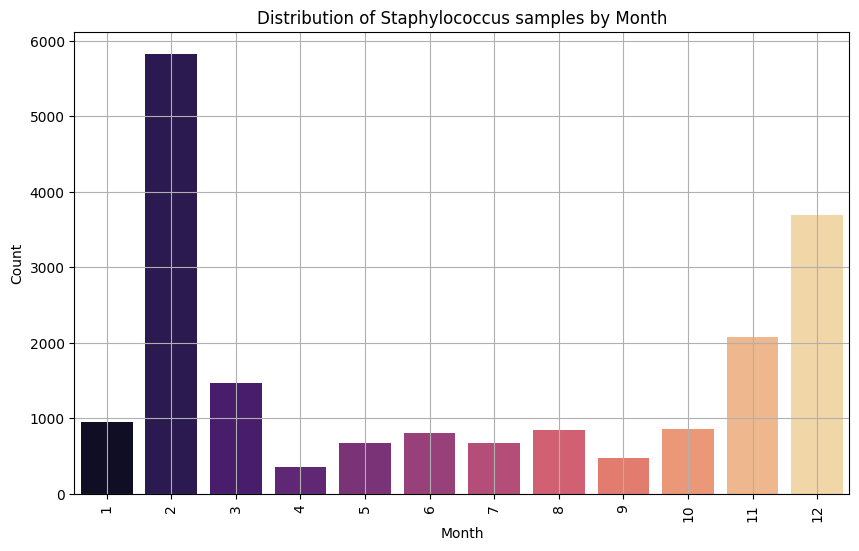

In [48]:
#now for the months: 
month_counts = df3['month'].value_counts().sort_index()

month_counts_df = month_counts.reset_index()
month_counts_df.columns = ['month', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='count', data=month_counts_df, palette="magma")
plt.title('Distribution of Staphylococcus samples by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

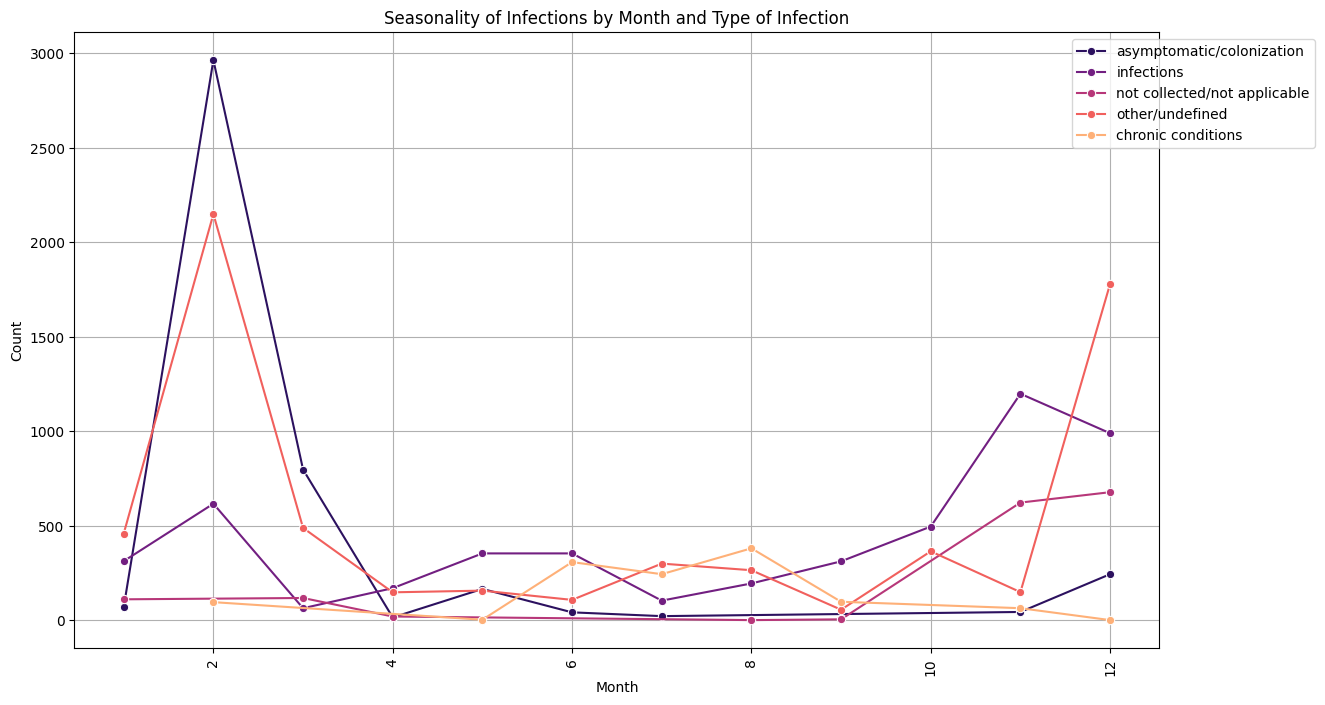

In [49]:
#Now, I wonder seasonality by type of infection

seasonality_data = df3.groupby(['month', 'host_disease']).size().reset_index(name='count')
plt.figure(figsize=(14, 8))
sns.lineplot(
    x='month', y='count', hue='host_disease', 
    data=seasonality_data, marker='o', palette="magma"
)
plt.title('Seasonality of Infections by Month and Type of Infection')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/3056477222.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genotype', y='count', data=amr_genotypes_df, palette="pastel")


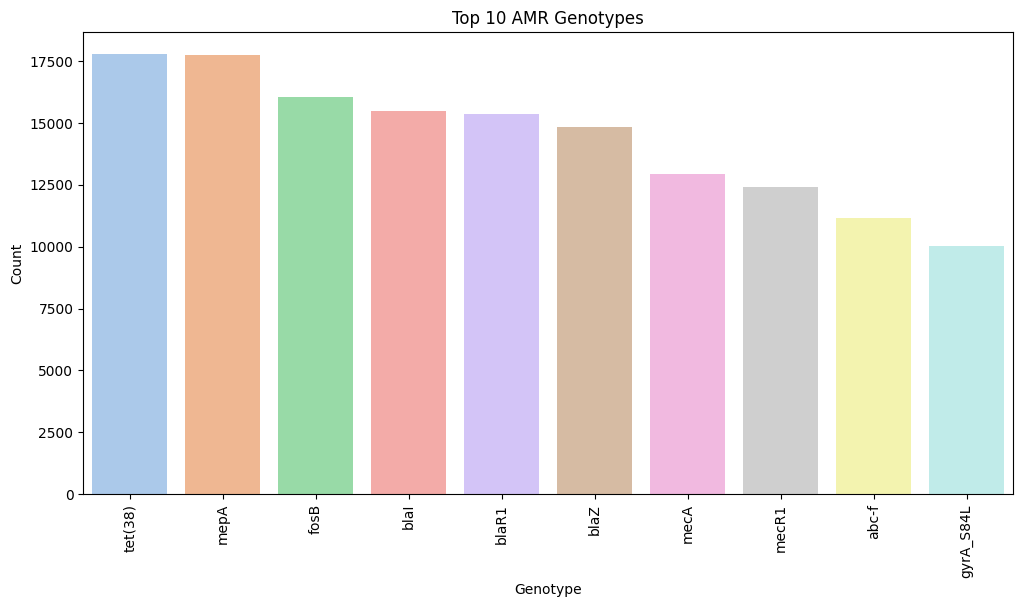

In [66]:
# Function to clean and correct the string format
def correct_format(val):
    if isinstance(val, str):
        val = "[" + val.strip('[]') + "]"
        val = re.sub(r"(?<!\w)'", '"', val)
        
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError) as e:
            print(f"Parsing error on value: {val} with error: {e}")
            return None
    elif isinstance(val, list):
        return val 
    return None

df3['amr_genotypes_corrected'] = df3['amr_genotypes'].apply(correct_format)

df3_cleaned = df3.dropna(subset=['amr_genotypes_corrected'])

amr_genotypes_flat = [genotype for sublist in df3_cleaned['amr_genotypes_corrected'] for genotype in sublist]
amr_genotype_counts = Counter(amr_genotypes_flat)

amr_genotypes_df = pd.DataFrame(amr_genotype_counts.most_common(10), columns=['genotype', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='genotype', y='count', data=amr_genotypes_df, palette="pastel")
plt.xticks(rotation=90)
plt.title('Top 10 AMR Genotypes')
plt.xlabel('Genotype')
plt.ylabel('Count')
plt.show()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/3337706073.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genotype', y='count', data=stress_genotypes_df, palette="pastel")


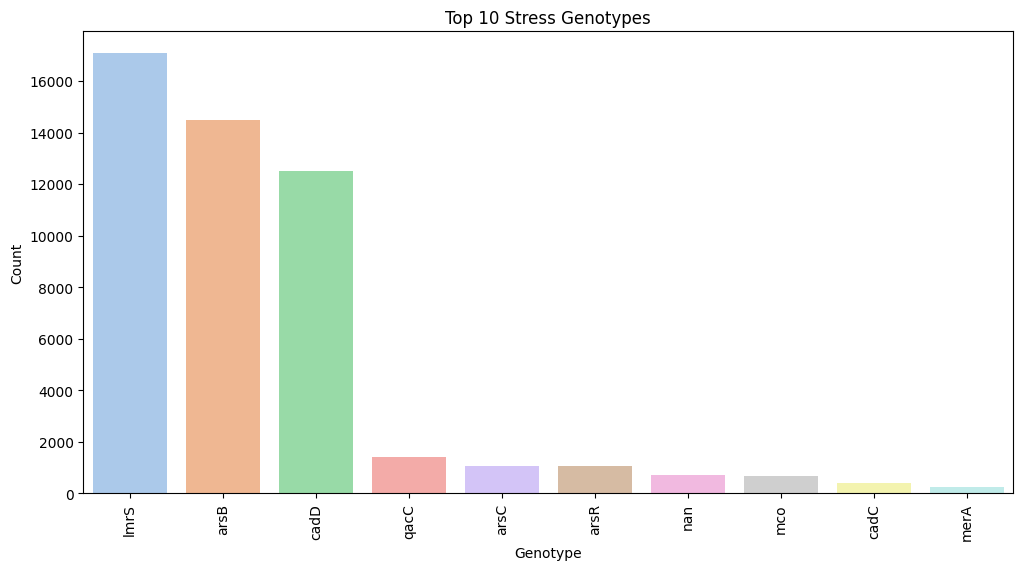

In [70]:
# Function to clean and correct the string format
def correct_format(val):
    if isinstance(val, str):
        val = "[" + val.strip('[]') + "]"
        val = re.sub(r"(?<!\w)'", '"', val)
        
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError) as e:
            print(f"Parsing error on value: {val} with error: {e}")
            return None
    elif isinstance(val, list):
        return val
    return None

df3['stress_genotypes_corrected'] = df3['stress_genotypes'].apply(correct_format)

df3_cleaned = df3.dropna(subset=['stress_genotypes_corrected'])

stress_genotypes_flat = [genotype for sublist in df3_cleaned['stress_genotypes_corrected'] for genotype in sublist]
stress_genotype_counts = Counter(stress_genotypes_flat)

stress_genotypes_df = pd.DataFrame(stress_genotype_counts.most_common(10), columns=['genotype', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='genotype', y='count', data=stress_genotypes_df, palette="pastel")
plt.xticks(rotation=90)
plt.title('Top 10 Stress Genotypes')
plt.xlabel('Genotype')
plt.ylabel('Count')
plt.show()


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/357434035.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='isolation_source', y='shannon_diversity', data=diversity_df, palette="pastel")


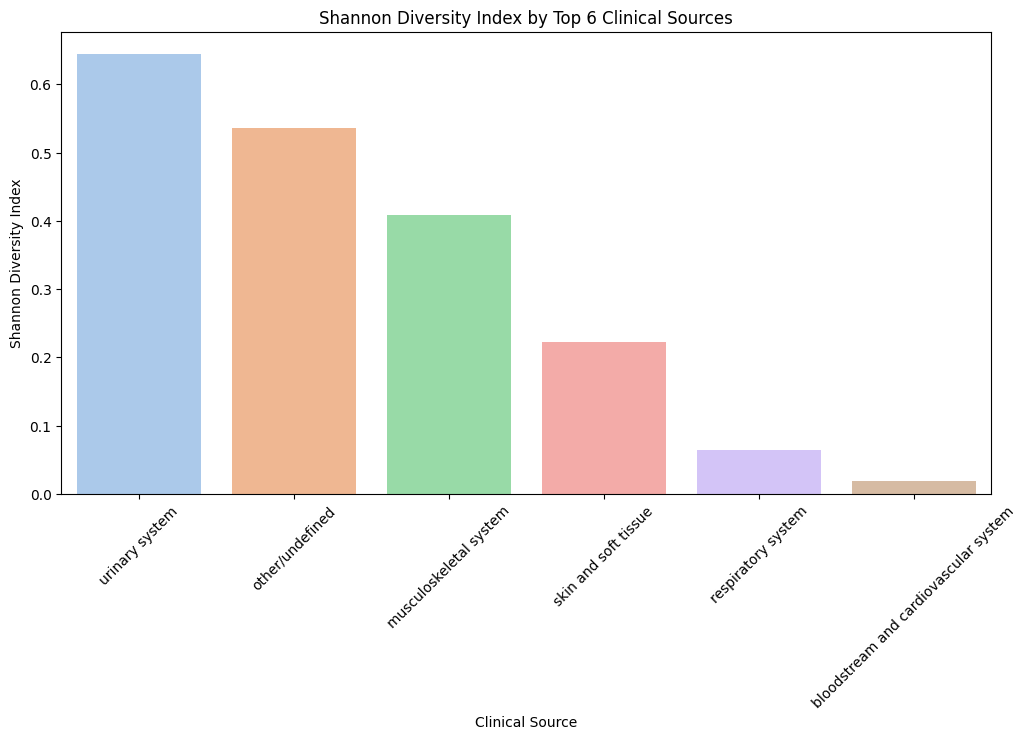

In [72]:
#Now that i have the EDA done, let's answer the research questions: 
#1. Diversity and distribution of Staphylococcus species across clinical sources

#1.1 What is the diversity of Staphylococcus species in different clinical sources (e.g., blood, throat, nose, endovascular, tissue)?# Function to calculate Shannon Diversity Index
def shannon_diversity_index(counts):
    total = sum(counts)
    proportions = [count / total for count in counts]
    return -sum(p * math.log(p) for p in proportions if p > 0)


top_sources = df3_cleaned['isolation_source'].value_counts().head(6).index

diversity_by_source = {}

filtered_df = df3_cleaned[df3_cleaned['isolation_source'].isin(top_sources)]

grouped = filtered_df.groupby('isolation_source')

for source, group in grouped:
    species_counts = Counter(group['organism_group'])

    diversity_by_source[source] = shannon_diversity_index(species_counts.values())

diversity_df = pd.DataFrame(list(diversity_by_source.items()), columns=['isolation_source', 'shannon_diversity'])
diversity_df = diversity_df.sort_values(by='shannon_diversity', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x='isolation_source', y='shannon_diversity', data=diversity_df, palette="pastel")
plt.xticks(rotation=45)
plt.title('Shannon Diversity Index by Top 6 Clinical Sources')
plt.xlabel('Clinical Source')
plt.ylabel('Shannon Diversity Index')
plt.show()


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/1821219177.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_distribution_df['proportion'] = top_distribution_df.apply(
/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/1821219177.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_distribution_df['sort_order'] = top_distribution_df.groupby('organism_group')['proportion'].rank(ascending=False)


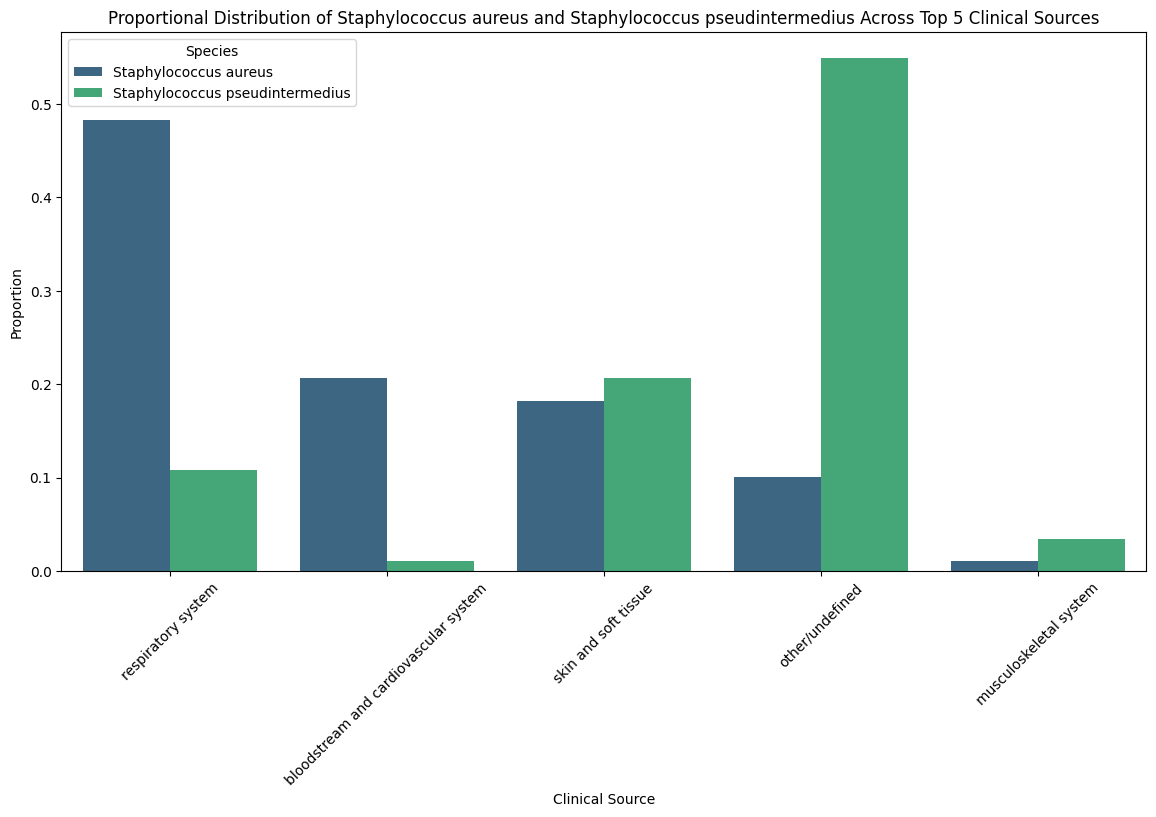

In [54]:
#Research question 1.2:How does the distribution of Staphylococcus aureus and Staphylococcus pseudointermedius vary across these clinical sources?

species_df = df3_cleaned[df3_cleaned['organism_group'].isin(['Staphylococcus aureus', 'Staphylococcus pseudintermedius'])]
distribution_df = species_df.groupby(['isolation_source', 'organism_group']).size().reset_index(name='count')

top_sources = distribution_df.groupby('isolation_source')['count'].sum().nlargest(5).index
top_distribution_df = distribution_df[distribution_df['isolation_source'].isin(top_sources)]

total_counts_per_species = species_df['organism_group'].value_counts()
top_distribution_df['proportion'] = top_distribution_df.apply(
    lambda row: row['count'] / total_counts_per_species[row['organism_group']], axis=1)

top_distribution_df['sort_order'] = top_distribution_df.groupby('organism_group')['proportion'].rank(ascending=False)
top_distribution_df = top_distribution_df.sort_values(by=['organism_group', 'sort_order'])

plt.figure(figsize=(14, 7))
sns.barplot(x='isolation_source', y='proportion', hue='organism_group', data=top_distribution_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Proportional Distribution of Staphylococcus aureus and Staphylococcus pseudintermedius Across Top 5 Clinical Sources')
plt.xlabel('Clinical Source')
plt.ylabel('Proportion')
plt.legend(title='Species')
plt.show()



In [55]:
#checking for statistical significative differences between the distribution across sources for both staphylococcus species: 
species_source_counts = pd.crosstab(df3_cleaned['isolation_source'], df3_cleaned['organism_group'])

total = species_source_counts.sum().sum()
expected_frequencies = np.outer(species_source_counts.sum(axis=1), species_source_counts.sum(axis=0)) / total

expected_frequencies = pd.DataFrame(expected_frequencies, index=species_source_counts.index, columns=species_source_counts.columns)

observed = species_source_counts.values
expected = expected_frequencies.values

chi_square_stat = ((observed - expected) ** 2 / expected).sum().sum()

df = (species_source_counts.shape[0] - 1) * (species_source_counts.shape[1] - 1)

p_value = 1 - np.exp(-0.5 * chi_square_stat) * sum((chi_square_stat ** k) / math.factorial(k) for k in range(df + 1))

print(f"Chi-Square Statistic: {chi_square_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of Staphylococcus species across clinical sources.")
else:
    print("There is no statistically significant difference in the distribution of Staphylococcus species across clinical sources.")

Chi-Square Statistic: 2400.44619249903
Degrees of Freedom: 10
P-Value: 1.0
There is no statistically significant difference in the distribution of Staphylococcus species across clinical sources.


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/1004357038.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_filtered.groupby(['organism_group', 'isolation_source']).apply(count_amr_genes).reset_index()


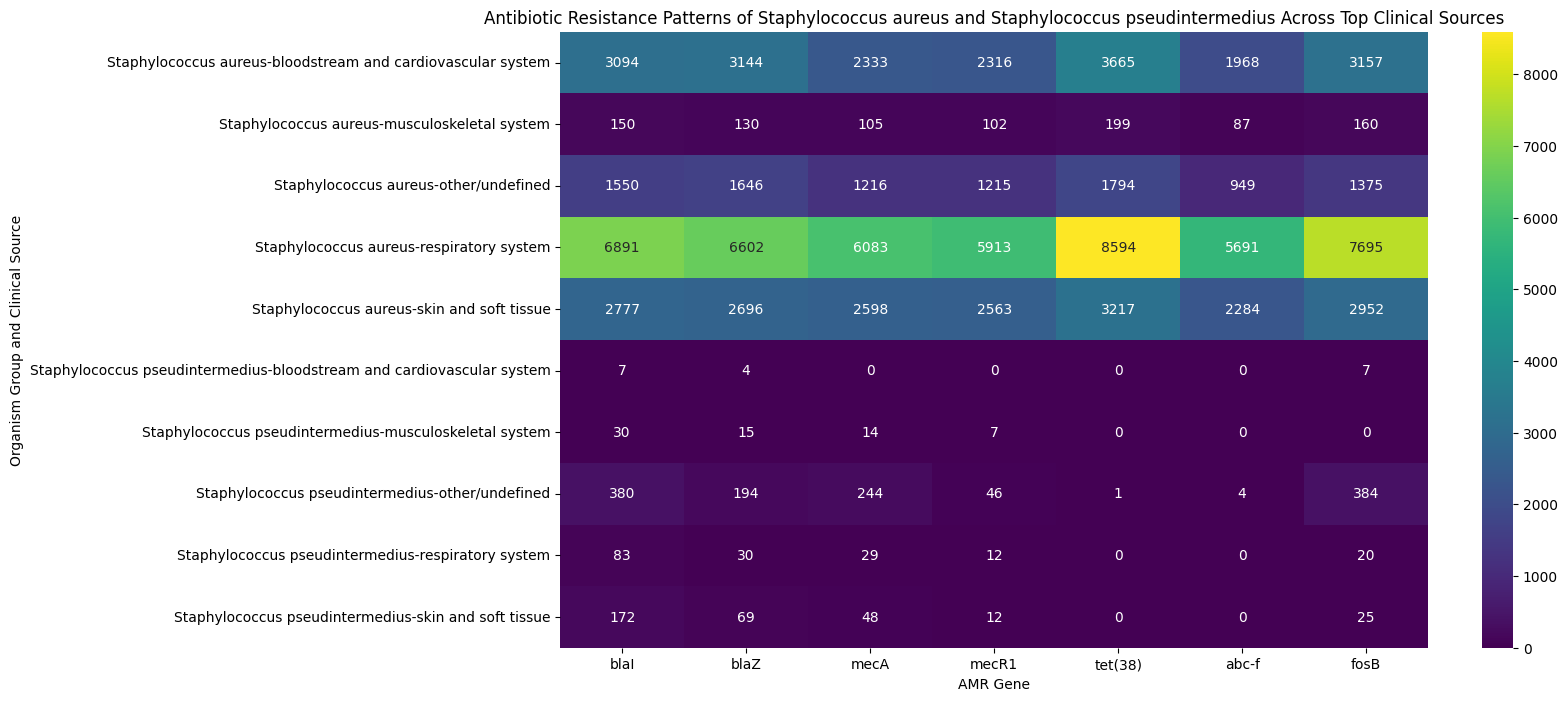

In [56]:
#Now, let's go with research question 3: What are the antibiotic resistance patterns of Staphylococcus aureus and Staphylococcus pseudointermedius isolates from various clinical sources?

top_clinical_sources = ['bloodstream and cardiovascular system', 'respiratory system', 'skin and soft tissue', 'other/undefined', 'musculoskeletal system']
top_amr_genes = ['blaI', 'blaZ', 'mecA', 'mecR1', 'tet(38)', 'abc-f', 'fosB']

df_filtered = df3_cleaned[df3_cleaned['isolation_source'].isin(top_clinical_sources)]

def count_amr_genes(group):
    amr_genes_flat = [gene for sublist in group['amr_genotypes_corrected'] for gene in sublist]
    return Counter(amr_genes_flat)

grouped = df_filtered.groupby(['organism_group', 'isolation_source']).apply(count_amr_genes).reset_index()
grouped.columns = ['organism_group', 'isolation_source', 'amr_genotypes_counts']

amr_genes_df = pd.DataFrame(grouped['amr_genotypes_counts'].tolist()).fillna(0)
grouped = grouped.drop('amr_genotypes_counts', axis=1).join(amr_genes_df)

filtered = grouped[['organism_group', 'isolation_source'] + top_amr_genes]

heatmap_data = filtered.set_index(['organism_group', 'isolation_source'])

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data[top_amr_genes], annot=True, cmap='viridis', fmt='g')
plt.title('Antibiotic Resistance Patterns of Staphylococcus aureus and Staphylococcus pseudintermedius Across Top Clinical Sources')
plt.xlabel('AMR Gene')
plt.ylabel('Organism Group and Clinical Source')
plt.show()



/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_4534/2065546880.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_s_aureus.groupby(['isolation_source']).apply(count_amr_genes).reset_index()


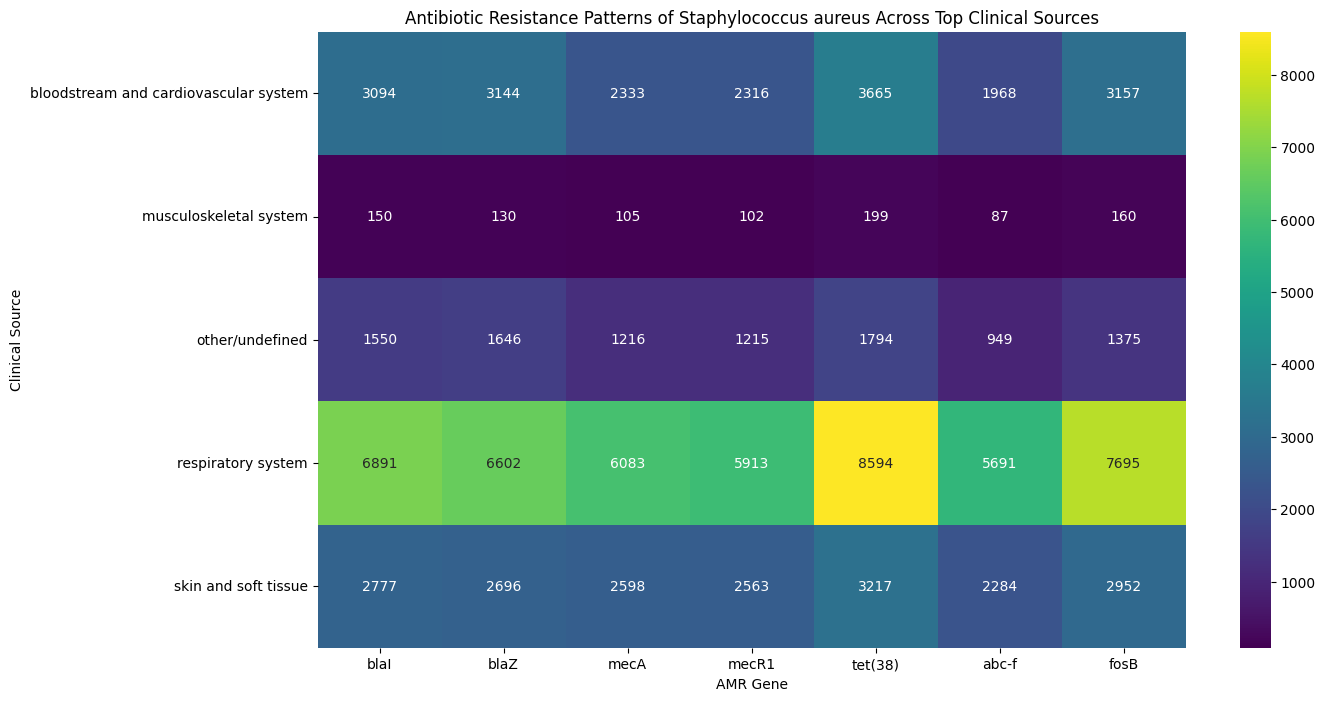

In [75]:
#For the presentation, I will plot only the AMR patterns for S. aureus.
top_clinical_sources = ['bloodstream and cardiovascular system', 'respiratory system', 'skin and soft tissue', 'other/undefined', 'musculoskeletal system']
top_amr_genes = ['blaI', 'blaZ', 'mecA', 'mecR1', 'tet(38)', 'abc-f', 'fosB']

df_s_aureus = df3_cleaned[(df3_cleaned['organism_group'] == 'Staphylococcus aureus') & (df3_cleaned['isolation_source'].isin(top_clinical_sources))]

def count_amr_genes(group):
    amr_genes_flat = [gene for sublist in group['amr_genotypes_corrected'] for gene in sublist]
    return Counter(amr_genes_flat)

grouped = df_s_aureus.groupby(['isolation_source']).apply(count_amr_genes).reset_index()
grouped.columns = ['isolation_source', 'amr_genotypes_counts']

amr_genes_df = pd.DataFrame(grouped['amr_genotypes_counts'].tolist()).fillna(0)
grouped = grouped.drop('amr_genotypes_counts', axis=1).join(amr_genes_df)

filtered = grouped[['isolation_source'] + top_amr_genes]

heatmap_data = filtered.set_index(['isolation_source'])

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data[top_amr_genes], annot=True, cmap='viridis', fmt='g')
plt.title('Antibiotic Resistance Patterns of Staphylococcus aureus Across Top Clinical Sources')
plt.xlabel('AMR Gene')
plt.ylabel('Clinical Source')
plt.show()



In [57]:
#research question 4: Are there significant differences in antibiotic resistance profiles between isolates from different clinical sources?

def count_amr_genes(amr_list, genes):
    return {gene: amr_list.count(gene) for gene in genes}

amr_genes = ['blaI', 'blaZ', 'mecA', 'mecR1', 'tet(38)', 'abc-f', 'fosB']
df_s_aureus = df_filtered[df_filtered['organism_group'] == 'Staphylococcus aureus']

amr_counts = df_s_aureus['amr_genotypes_corrected'].apply(lambda x: count_amr_genes(x, amr_genes) if isinstance(x, list) else {})
amr_counts_df = pd.json_normalize(amr_counts)
amr_counts_df['isolation_source'] = df_s_aureus['isolation_source'].reset_index(drop=True)
aggregated_amr_counts = amr_counts_df.groupby('isolation_source').sum()

contingency_table = aggregated_amr_counts
contingency_table = contingency_table.loc[:, (contingency_table != 0).any(axis=0)]

observed = contingency_table.values
total = observed.sum()
expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / total

chi_square_stat = ((observed - expected) ** 2 / expected).sum()

df = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
p_value = 1 - sum(math.exp(-0.5 * chi_square_stat) * (chi_square_stat ** k) / math.factorial(k) for k in range(df + 1))

print(f"Chi-Square Statistic: {chi_square_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in the antibiotic resistance profiles between isolates from different clinical sources.")
else:
    print("There is no statistically significant difference in the antibiotic resistance profiles between isolates from different clinical sources.")

Chi-Square Statistic: 282.17300896262043
Degrees of Freedom: 24
P-Value: 1.0
There is no statistically significant difference in the antibiotic resistance profiles between isolates from different clinical sources.
